In [ ]:
# Instalar librerías
!pip install transformers --quiet

In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

# Usar el GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Establecer el directorio de trabajo
%cd /content/drive/MyDrive/University/8th\ Semester/5.\ Scientific\ Communication\ Workshop/X_Fake_News_Detection

/content/drive/MyDrive/University/8th Semester/5. Scientific Communication Workshop/X_Fake_News_Detection


In [ ]:
# Cargar el dataset
df = pd.read_csv("./data.csv")

df = df.dropna()
df['real'] = df['real'].astype(int)

df

,text,real
0,#URGENTE 🔴 EL PUEBLO SE LEVANTO EN #QUITO TRAS...,0
1,¡Veedores de lejitos no más!\nPor disposición ...,0
2,#DefiendeTuVoto\n#EICNEqueTenemos\nDENUNCIA\nL...,0
3,Según el articulo 127 del Código de la Democra...,0
4,Me cuentan que en Carondelet supuestamente tie...,0
...,...,...
617,Un comparativo desde 2017 hasta los resultados...,1
618,"La organización indígena Conaie, liderada por ...",1
619,Inteligencia militar emitió 10 alertas de inte...,1
620,El Pleno del CNE negó la mañana de este jueves...,1


([<matplotlib.patches.Wedge at 0x79f943a00d50>,
 [Text(-1.197796570051217, -0.07268684044268377, '0'),
  Text(1.197796570051217, 0.07268684044268416, '1')],
 [Text(-0.69871466586321, -0.04240065692489886, '51.9%'),
  Text(0.6987146658632097, 0.04240065692489908, '48.1%')])

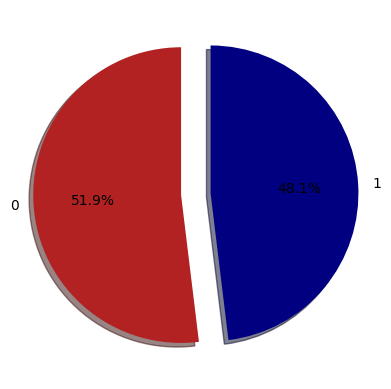

In [ ]:
# Chequear si nuestros datos están bien balanceados
label_size = [df['real'].sum(), len(df['real']) - df['real'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'], startangle = 90, shadow = True, labels = ['0', '1'], autopct = '%1.1f%%')

In [ ]:
# Conjunto Prueba-Validación-Prueba dividido en un radio 70:15:15
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['real'].tolist(), stratify=df['real'], test_size=0.3, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, stratify=temp_labels, test_size=0.5, random_state=42)

In [ ]:
# Elegir modelo
model_name = "dccuchile/bert-base-spanish-wwm-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Tokenización
def tokenize(texts, max_len=400):
    return tokenizer.batch_encode_plus(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

In [ ]:
# Crear DataLoaders
def create_dataset(encodings, labels):
    return TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

train_dataset = create_dataset(train_encodings, train_labels)
val_dataset = create_dataset(val_encodings, val_labels)
test_dataset = create_dataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=16)
val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=16)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=16)

In [ ]:
# Definir arquitectura
class BETOClassifier(nn.Module):
    def __init__(self, model_name):
        super(BETOClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # BETO uses pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BETOClassifier(model_name).to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizador y criterio
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Entrenamiento y evaluación
def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

In [ ]:
# Entrenamiento
for epoch in range(2):
    loss = train_epoch(model, train_loader)
    print(f"Epoch {epoch+1} | Train Loss: {loss:.4f}")

Epoch 1 | Train Loss: 0.5328
Epoch 2 | Train Loss: 0.2345


In [ ]:
# Evaluación final en test
preds, trues = evaluate(model, test_loader)
print(classification_report(trues, preds, digits=4))

              precision    recall  f1-score   support

           0     0.8837    0.8444    0.8636        45
           1     0.8627    0.8980    0.8800        49

    accuracy                         0.8723        94
   macro avg     0.8732    0.8712    0.8718        94
weighted avg     0.8728    0.8723    0.8722        94

